<a href="https://colab.research.google.com/github/luismedina25/Analysis-of-Crash-reports/blob/main/Analysis_of_crash_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A superficial analysis of crash report data**

## **Introduction**

This report reviews vehicle crash data from Maryland's Montgomery County. The dataset was collected via the Automated Crash Reporting System (ACRS) from the Maryland State Police. Also, data was collected based on the information that was reported by the parties involved,meaning that the information may contain errors or can be updated at a future time. They first start collecting in September 19, 2017 and it's still being updated to this day. For our purpose we saved an instance of the data so that it is the same throughout the making of this report. 

The main aim of this report is to explore the data. We found some interesting things that we will explain in the conclusion. We drop a lot of the data that is either incomplete or not useful to us. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = pd.read_csv('/content/drive/My Drive/Data/Crash_report.csv')

df = raw_data.copy()
df.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108931 entries, 0 to 108930
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   108931 non-null  object 
 1   Local Case Number               108931 non-null  object 
 2   Agency Name                     108931 non-null  object 
 3   ACRS Report Type                108931 non-null  object 
 4   Crash Date/Time                 108931 non-null  object 
 5   Route Type                      98507 non-null   object 
 6   Road Name                       99008 non-null   object 
 7   Cross-Street Type               98495 non-null   object 
 8   Cross-Street Name               99004 non-null   object 
 9   Off-Road Description            9922 non-null    object 
 10  Municipality                    11902 non-null   object 
 11  Related Non-Motorist            3341 non-null    object 
 12  Collision Type  

In [ ]:
df.shape

(108931, 43)

From looking at the dataset we can see that it has 108,931 rows and 43 columns. Just from looking at the info we can see that the majority of the columns are not integers. Poking through the data we see that most of the columns are catagorical and not numeric.

In [ ]:
df.isna().sum()

Report Number                          0
Local Case Number                      0
Agency Name                            0
ACRS Report Type                       0
Crash Date/Time                        0
Route Type                         10424
Road Name                           9923
Cross-Street Type                  10436
Cross-Street Name                   9927
Off-Road Description               99009
Municipality                       97029
Related Non-Motorist              105590
Collision Type                       361
Weather                             8598
Surface Condition                  12871
Light                                907
Traffic Control                    17406
Driver Substance Abuse             20126
Non-Motorist Substance Abuse      106285
Person ID                              0
Driver At Fault                        0
Injury Severity                        0
Circumstance                       87637
Driver Distracted By                   0
Drivers License 

For some columns where the null values make up 80% or more of the values, we will drop them.

In [ ]:
print(df['Related Non-Motorist'].isna().mean())
print(df['Municipality'].isna().mean())
print(df['Off-Road Description'].isna().mean())
print(df['Non-Motorist Substance Abuse'].isna().mean())
print(df['Circumstance'].isna().mean())

0.9693292083979766
0.8907381737062912
0.9089148176368527
0.9757093940200677
0.8045184566376881


Some columns have a lot data, but they still don't tell us anything. For example, the column Equipment Problems is dominated by one value "NO MISUSE". The next most frequent value is 'UNKNOWN'. This suggests either incomplete data collection, or that improper use of safety equipment is so rare it can be neglected. The driverless Vehicle column is also dominated by "NO" and "UNKOWN". The parked vehicle column is the same story. We will drop these columns. The histogram below is an example of such columns. 


Text(0.5, 1.0, "Values in 'Equipment Problems'")

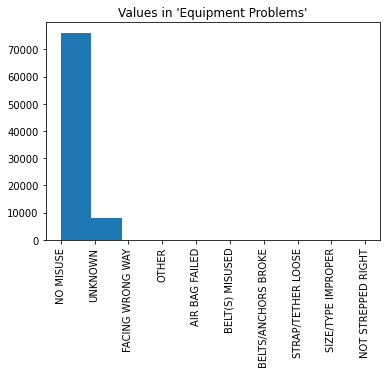

In [ ]:
eq_prb = df['Equipment Problems']
non_null_eq_prb = eq_prb[eq_prb.notna()]
plt.hist(non_null_eq_prb)
plt.xticks(rotation=90)
plt.title("Values in 'Equipment Problems'")

Some columns are really only useful for clerical use by the local agencies handling the crash. Such columns, like Local Case Number and Report Number are close to meaningless for our purpose, we will drop them. The location column is also redundant. 

Lets convert the time to proper pandas time and set the index to the time and drop the tables we are not interested in keeping, Let's also take a look at what our dataframe looks like after droppping some columns. 

In [ ]:
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'])
df.set_index('Crash Date/Time', inplace=True)

df.drop(inplace=True, columns=[
  'Off-Road Description',
  'Related Non-Motorist',
  'Municipality',
  'Circumstance',
  'Non-Motorist Substance Abuse',
  'Equipment Problems',
  'Driverless Vehicle',
  'Parked Vehicle',
  'Local Case Number',
  'Report Number',
  'Person ID',
  'Vehicle ID',
  'Location'                             
])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108931 entries, 2019-05-19 17:23:00 to 2017-09-27 11:54:00
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Agency Name                     108931 non-null  object 
 1   ACRS Report Type                108931 non-null  object 
 2   Route Type                      98507 non-null   object 
 3   Road Name                       99008 non-null   object 
 4   Cross-Street Type               98495 non-null   object 
 5   Cross-Street Name               99004 non-null   object 
 6   Collision Type                  108570 non-null  object 
 7   Weather                         100333 non-null  object 
 8   Surface Condition               96060 non-null   object 
 9   Light                           108024 non-null  object 
 10  Traffic Control                 91525 non-null   object 
 11  Driver Substance Abuse          88805 non-nu

## **Investigating Driver Distraction**

The 'Driver Distracted By' column be an interesting place to start poking around in the data, it has the benefit of having no null values. We noticed that of the values that occur, many of them pertain to distraction from electronic devices. We consolodated 5 value types that are related to electronic devices to the value 'ELECTRONIC DEVICE'. But you can see in the plot below that the new value pales in comparison to the 'NOT DESTRACTED' value. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Reasons For Distracting against their Frequency')

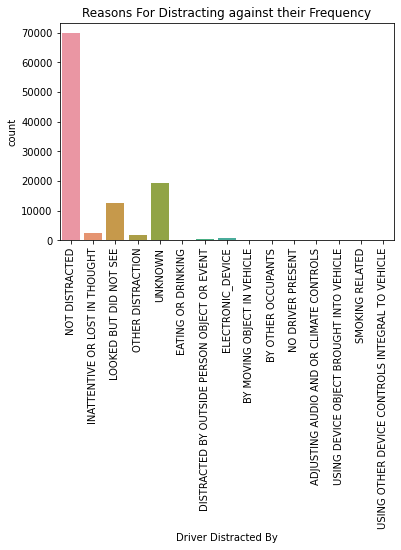

In [ ]:
def electronic_device(x):
  electronic_device_related = (
      x == 'OTHER CELLULAR PHONE RELATED' or 
      x == 'DIALING CELLULAR PHONE' or 
      x == 'TALKING OR LISTENING TO CELLULAR PHONE' or
      x == 'OTHER ELECTRONIC DEVICE (NAVIGATIONAL PALM PILOT)' or
      x == 'TEXTING FROM A CELLULAR PHONE'
  )
  if electronic_device_related: return 'ELECTRONIC_DEVICE'
  else: return x

df['Driver Distracted By'] = df['Driver Distracted By'].apply(electronic_device)
distracted = df['Driver Distracted By']
p = sns.countplot(distracted)
hide_text = p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.set_title('Reasons For Distracting against their Frequency')

We might get more from this information if we added a column of booleans called 'Distracted'.

In [ ]:
df['Distracted'] = df['Driver Distracted By'] != 'NOT DISTRACTED'
print("distracted     : " + str(df.Distracted.mean()))
print("not distracted : " + str(1-df.Distracted.mean()))

distracted     : 0.35908051886056314
not distracted : 0.6409194811394369


Only 36% of drivers involved in a crash were distracted? That seems odd. It looks like people who where distracted didn't realize they were, or simply lied in the report. Unfortunatly that could mean that our data for distracted drivers overly represents honest drivers. But lets run with it anyways and see if it has anything to do with whether or not they are at fault. 

In [ ]:
print( (df['Distracted'] & (df['Driver At Fault'] == 'Yes') ).mean() )
print( (~df['Distracted'] & (df['Driver At Fault'] == 'Yes') ).mean() )
print( (df['Distracted'] & (df['Driver At Fault'] == 'No') ).mean() )
print( (~df['Distracted'] & (df['Driver At Fault'] == 'Yes') ).mean() )

0.3281894043018057
0.20526755469058394
0.01879171218477752
0.20526755469058394


About 32% of drivers in the report were distracted and at fault. 21% of drivers were 'paying attention' and not at fault. Only about 2% were distracted and not at fault, that makes sense. Most of the drivers, 42%, were paying attention and were not at fault. This all seems reasonable. Where distracted drivers more likely to be at fault? Lets answer that by first creating a column of booleans called 'At Fault'. What to do with unknown values? Lets just assume that they were at fault, after all that is the mode for this column and most drivers know there is almost always something you can do to avoid a crash.

In [ ]:
df['At Fault'] = ~(df['Driver At Fault'] == 'No')

print( df['Distracted'][df['At Fault']].mean() )
print( (~df['Distracted'])[df['At Fault']].mean() )
print( df['Distracted'][~df['At Fault']].mean() )
print( (~df['Distracted'])[~df['At Fault']].mean() )

0.6108263986158029
0.3891736013841971
0.042428387845624506
0.9575716121543755


What we see from this is not surprising, 61% of people who were distracted were also responsible. 91% of people paying attention were not responsible. Nearly 40% of people who were paying attention were at fault, those must be the rode ragers. Only about 4% of people were not paying attention and were not at fault. This all seems to fit with intuition and answers our question. Distracted people had a 61% probability of being at fault where as drivers who were paying attention had a 39% probability of being at fault. 

## **Investigating Car Types** 

Lets look at car data. We know that we can probably find a corrolation between intoxication and severity of crash, but something slightly less obvious might be a relationship between type of car and severity of crash. Lets first get a feel for what types of cars we have. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Types of car against their Frequency')

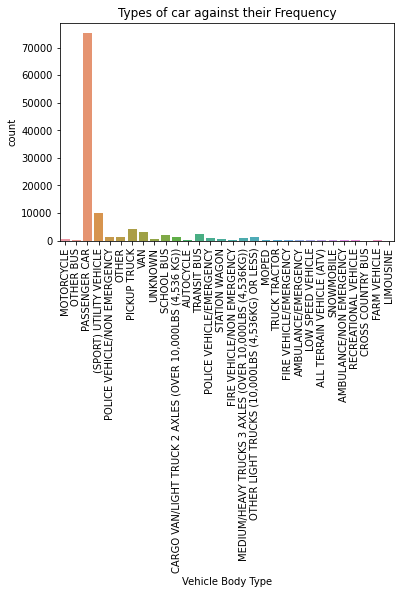

In [ ]:
p = sns.countplot(df['Vehicle Body Type'])
hide_text = p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.set_title('Types of car against their Frequency')


In [ ]:
df['Vehicle Make'].value_counts().head(30)

TOYOTA       14403
HONDA        11672
FORD         11045
TOYT          5699
NISSAN        5519
HOND          3648
DODGE         2875
CHEV          2416
CHEVROLET     2415
HYUNDAI       2331
JEEP          2281
CHEVY         2058
BMW           2053
UNKNOWN       2041
LEXUS         1829
ACURA         1828
NISS          1782
KIA           1478
MAZDA         1354
HYUN          1307
SUBARU        1272
GMC           1233
THOMAS        1114
MERZ          1090
MERCEDES       835
AUDI           804
GILL           749
CHRYSLER       684
VOLK           652
ACUR           626
Name: Vehicle Make, dtype: int64

Looking at this we can see that it is a mess as Toyota is represented as 'TOYOTA' and 'TOYT'. Acura is represesnted as 'ACURA' and 'ACUR', so an and so forth for many different car makes. there are 1.389 different values in the Vehicle Make column, consolidating the inccorectly recorded data will take a look at the Vehicle year.

In [ ]:
df['Vehicle Year'].value_counts()

2015    7766
2014    7738
2013    7350
2016    6493
2012    6418
        ... 
1959       1
1234       1
2102       1
2998       1
2911       1
Name: Vehicle Year, Length: 121, dtype: int64

Looking at the value count we see that there are errors in the data. One car was made in the year 2911, and another in the 13th century. Lets see how many data points are rediculuos. 

In [ ]:
total_values = df['Vehicle Year'].size
rediculous_values = df['Vehicle Year'][(df['Vehicle Year'] > 2017) | (df['Vehicle Year'] < 1950)].size
rediculous_values / total_values 

0.05903737228153602

Only 6% of entries are unreasonable. We are assuming folks who are still driving their model year 1950 or earlier are not the ones getting into accidents. Lets replace all bad values with 0 and ignore them. Lets also make a boolean column called 'Valid year' to help us split series down the line.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Vehicle Year Frequency in data set')

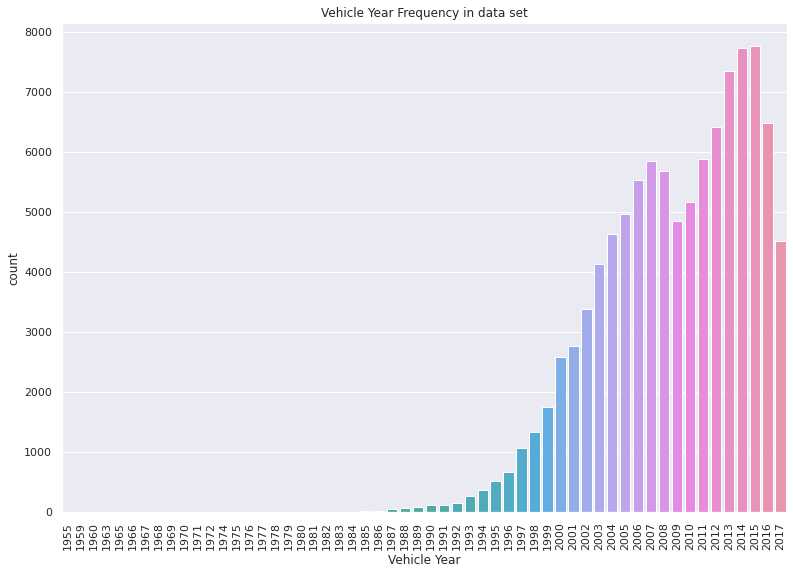

In [ ]:
def replace_crazy_values_with_0(x):
  if (x > 2017) or (x < 1950): return 0
  return x

df['Vehicle Year'] = df['Vehicle Year'].apply(replace_crazy_values_with_0)
df['Valid Year'] = df['Vehicle Year'] != 0
p = sns.countplot(df['Vehicle Year'][df['Valid Year']])
hide_text = p.set_xticklabels(p.get_xticklabels(), rotation=90)
sns.set(rc={'figure.figsize':(13,10)})
p.set_title('Vehicle Year Frequency in data set')

## **Vehicle Year and Injury**

It would be interesting to plot injury severity against vehicle year. Lets first check out the Injury Severity column and clean it up. 

NO APPARENT INJURY          88677
POSSIBLE INJURY             11222
SUSPECTED MINOR INJURY       8050
SUSPECTED SERIOUS INJURY      909
FATAL INJURY                   73
Name: Injury Severity, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Frequency of Recorded Injury Types')

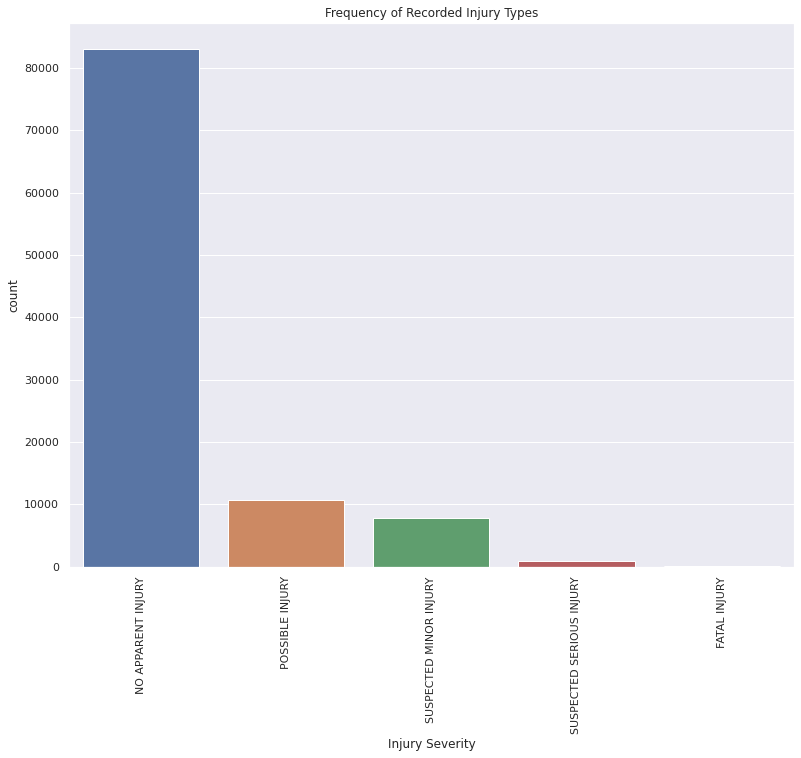

In [ ]:
print( df['Injury Severity'].value_counts() )
p = sns.countplot(df['Injury Severity'][df['Vehicle Year'] != 0])
hide_text = p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.set_title('Frequency of Recorded Injury Types')

Looks pretty clean. Lets look at injury severity vs vehicle year.

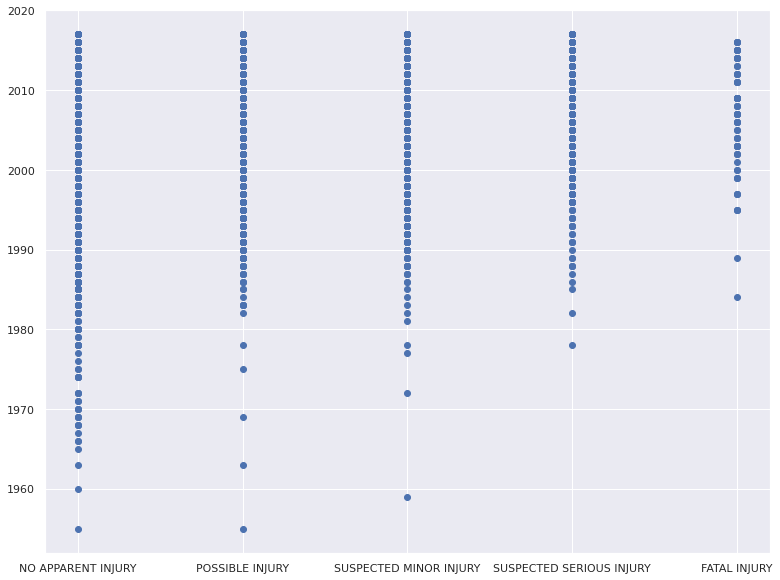

In [ ]:
plt.scatter(df['Injury Severity'][df['Valid Year']], df['Vehicle Year'][df['Valid Year']])

There is the slightest hint of a trend towards newer vehicles being more deadly. This makes sense for a couple reasons. Drivers of old cars don't drive as fast. Newer cars handle high speeds better. One possible factor that is probably too speculative is that drivers of newer cars are the spoiled brats who can afford newer cars. What doesn't make sense is that you would expect newer cars to have top of the line safety equipment like airbags. But if our theory is that newer cars are getting into crashes at very high speeds, airbags won't help much. 

Lets see if newer cars are more likely to crash where the speed limit is higher. Lets call a newer car any car that was made after 2010 and add a boolean column to the dataframe called 'Newer Car'.

In [ ]:
df['Newer Car'] = df['Vehicle Year'].apply(lambda x: x > 2010)
print("% of newer cars: " + str(df['Newer Car'].mean()))
print("% of older cars: " + str(1-df['Newer Car'].mean()))

% of newer cars: 0.4238646482635797
% of older cars: 0.5761353517364203


Lets look at two histograms, one will be speed limit frequencies for old cars and the other will be speed limit frequencies for newer cars.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Speed Limit Frequencies for Newer Cars')

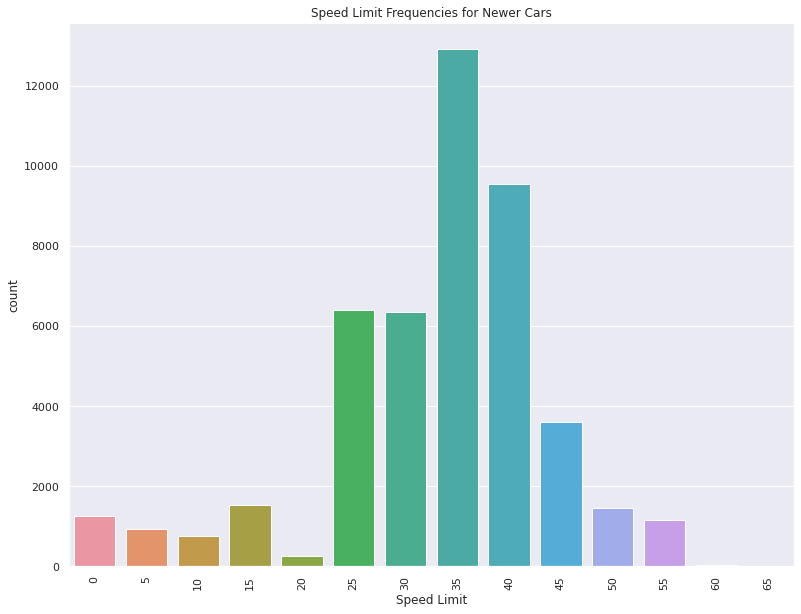

In [ ]:
new = df['Speed Limit'][df['Newer Car']]
old = df['Speed Limit'][~df['Newer Car']]
s = sns.countplot(new)
hide_text = s.set_xticklabels(s.get_xticklabels(), rotation=90)
s.set_title('Speed Limit Frequencies for Newer Cars')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Speed Limit Frequencies for Older Cars')

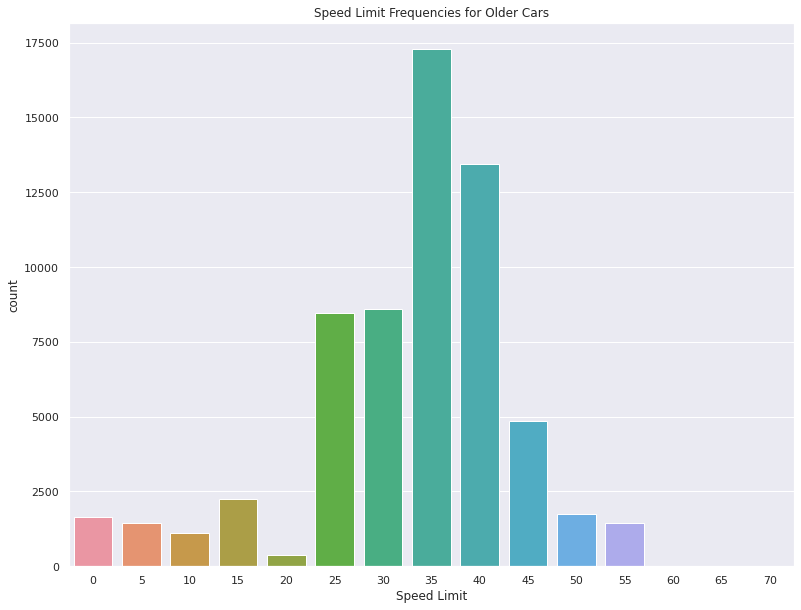

In [ ]:
s1 = sns.countplot(old)
hide_text = s.set_xticklabels(s.get_xticklabels(), rotation=90)
s1.set_title('Speed Limit Frequencies for Older Cars')

Believe it or not, those are two different histograms. The similarity of the shape of thier distrobutions are remarkable. What we see in this is that the vast majority of crashes happen on streets, likely at intersections, and regardless of whether you are behind the wheel of a new car, or an old car.

In [ ]:
print( "Mean speed limit never: " + str((df['Speed Limit'][df['Newer Car']]).mean()) )
print( "Mean speed limit older: " + str((df['Speed Limit'][~df['Newer Car']]).mean()) )

Mean speed limit never: 33.005609460278954
Mean speed limit older: 32.85895250083653


The mean speed limit for newer cars is just a hair over the mean speed limit for old cars. This doesn't say anything about their actual speeds, the only thing this metric really says is that maybe newer cars drivers are more likely to take the freeway.


Lets look at speed limit plotted against injury severity with a violin plot.

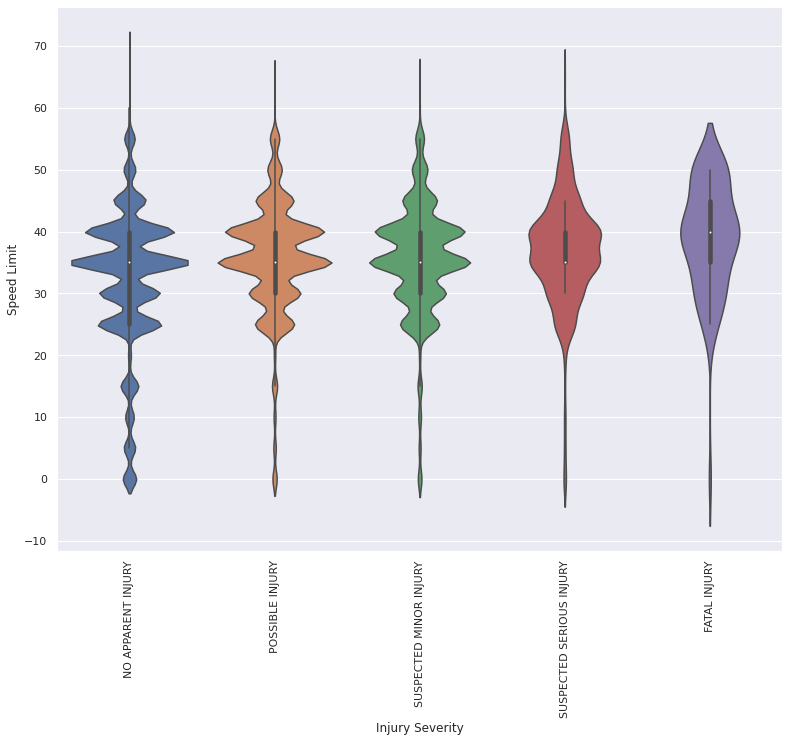

In [ ]:
injury = df['Injury Severity']
speed_limit = df['Speed Limit']
s = sns.violinplot(x = injury, y=speed_limit)
hide_text = s.set_xticklabels(s.get_xticklabels(), rotation=90)

This is interesting. We see from the violin plot that speed limits like 40 and 30 miles per hour are popular for injuries. This seems to suggest intersections. For fatal injuries, the highest occuring speed limit is 40 mph. To us that sounds like T-bones at intersections. 

Lets pick on drivers of new cars a little more. Lets see if new cars are more likely to be involved in lethal accidents. 

In [ ]:
df['Fatal'] = df['Injury Severity'].apply(lambda x: x == 'FATAL INJURY')

In [ ]:
valid = df['Valid Year']

new = df['Newer Car']
fatal = df['Fatal']

fatal = fatal[valid]
new = new[valid]

old = ~new

print( "% Fatal accidents involving new cars: " + str(round(new[fatal].mean()*100, 2) ) + "%")
print( "% Fatal accidents involving new cars: " + str(round(old[fatal].mean()*100, 2) ) + "%")

print( "% of newer cars: " + str(round(df['Newer Car'].mean(),2)) + "%")
print( "% of newer cars: " + str(round(1-df['Newer Car'].mean(),2)) + "%")

% Fatal accidents involving new cars: 34.29%
% Fatal accidents involving new cars: 65.71%
% of newer cars: 0.42%
% of newer cars: 0.58%


Here we see that if we draw the line between new car and old car at 2010, newer cars account for 42% of the crashes, but only 35% of the deadly crashes. This seems to contradict the plot we made earlier, but 2010 is splits the data pretty evenly, and doesn't reflect the newest cars very well. 

## **Conclusion**

To conclude we found that there may be a trend toward newer cars being deadlier, but our results were inconclusive, we would need to revisit the problem with a more exclusive definition of 'new'.

We found a strong relationship between distractedness and culpability. 61% of people who were distracted were also responsible for the crash. A whopping 91% of people who were paying attention to the road were not responsible. 

The most interesting thing we found was that most crashes, including most deadly crashes happen at reletively low speed zones like 30 or 40 mph. To us that means intersections. We don't think people are crashing at freeways speeds as much. 

There is so much in this data set, far more than what our alloted time allowed for. Most of the data cleaning and pre-processing we did was with an eye towards future work with this data set, and unfortunatly we did not have the time really use some of the pre-processing we did, as well as of the tools we set up. 